---

## 1. OVERVIEW & METHODOLOGY

# Phase 1: Data Preparation

**Experiment Phase:** Phase 1 - Algorithmus-Vergleich  
**Date:** 2026-01-19  
**Author:** Silas Pignotti  
**Expected Runtime:** ~5-10 minutes

---

### 1.1 Purpose

This notebook prepares all datasets for Phase 1 experiments by applying Phase 0 decisions:

- Load **selected_features.json** (Top-50 features from Experiment 0.3)
- Extract Top-50 features from all city datasets (Berlin, Hamburg, Rostock)
- Export as **Parquet** files (faster loading than GeoPackage for ML)
- Validate data integrity (genera counts, feature names, missing values)

**Output:** Pre-processed datasets ready for RF/XGBoost/NN training and Hamburg/Rostock transfer tests.

### 1.2 Workflow

```
[PHASE 1: LOAD PHASE 0 CONFIG]
├── Load selected_features.json (Top-50)
├── Validate feature list
└── Log configuration

    ↓

[PHASE 2: PROCESS BERLIN (Train/Val)]
├── Load berlin_20m_edge_train.gpkg
├── Load berlin_20m_edge_val.gpkg
├── Extract Top-50 features + genus_latin
├── Validate (genera count, NaN check)
└── Export as Parquet

    ↓

[PHASE 3: PROCESS HAMBURG (Transfer Test)]
├── Load hamburg_20m_edge.gpkg
├── Extract Top-50 features + genus_latin
├── Validate (overlap with Berlin genera)
└── Export as Parquet

    ↓

[PHASE 4: PROCESS ROSTOCK (Transfer Test)]
├── Load rostock_20m_edge.gpkg
├── Extract Top-50 features + genus_latin
├── Validate (overlap with Berlin genera)
└── Export as Parquet

    ↓

[OUTPUT: Preprocessed Datasets]
├── berlin_20m_edge_top50_train.parquet
├── berlin_20m_edge_top50_val.parquet
├── hamburg_20m_edge_top50.parquet
├── rostock_20m_edge_top50.parquet
└── data_prep_report.json (validation stats)
```

### 1.3 Expected Outputs

| File | Type | Description |
|------|------|-------------|
| berlin_20m_edge_top50_train.parquet | Parquet | Berlin training set (Top-50 features) |
| berlin_20m_edge_top50_val.parquet | Parquet | Berlin validation set (Top-50 features) |
| hamburg_20m_edge_top50.parquet | Parquet | Hamburg transfer test set (Top-50 features) |
| rostock_20m_edge_top50.parquet | Parquet | Rostock transfer test set (Top-50 features) |
| data_prep_report.json | JSON | Validation statistics and metadata |

---

## 2. SETUP & IMPORTS

### 2.1 Packages & Environment

In [18]:
# Core libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import json
from pathlib import Path
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

print("Imports successful")

Imports successful


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.2 Visualization & Utility Functions

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

PUBLICATION_STYLE = {
    'style': 'seaborn-v0_8-whitegrid',
    'figsize': (12, 7),
    'dpi_export': 300,
}

def setup_publication_style():
    plt.rcdefaults()
    plt.style.use(PUBLICATION_STYLE['style'])
    sns.set_palette('Set2')
    plt.rcParams['figure.figsize'] = PUBLICATION_STYLE['figsize']
    plt.rcParams['savefig.dpi'] = PUBLICATION_STYLE['dpi_export']
    print("Publication style configured")

setup_publication_style()

Publication style configured


In [21]:
def print_section(title):
    """Print formatted section header."""
    print("\n" + "="*70)
    print(f"  {title}")
    print("="*70 + "\n")

def print_subsection(title):
    """Print formatted subsection header."""
    print("\n" + "-"*70)
    print(f"  {title}")
    print("-"*70 + "\n")

def validate_features(gdf, required_features, label_col='genus_latin'):
    """Validate that all required features exist in GeoDataFrame."""
    missing = [f for f in required_features if f not in gdf.columns]

    if missing:
        print(f"ERROR: Missing {len(missing)} features:")
        for f in missing[:10]:
            print(f"  - {f}")
        if len(missing) > 10:
            print(f"  ... and {len(missing)-10} more")
        return False

    if label_col not in gdf.columns:
        print(f"ERROR: Label column '{label_col}' not found")
        return False

    return True

def check_missing_values(df, features):
    """Check for missing values in features."""
    missing_counts = df[features].isnull().sum()
    missing_features = missing_counts[missing_counts > 0]

    if len(missing_features) > 0:
        print(f"WARNING: {len(missing_features)} features with missing values:")
        for feat, count in missing_features.head(10).items():
            pct = count / len(df) * 100
            print(f"  {feat}: {count} ({pct:.2f}%)")
        return False
    else:
        print("No missing values detected")
        return True

print("Utility functions defined")

Utility functions defined


---

## 3. CONFIGURATION & PARAMETERS

### 3.1 Paths

In [22]:
# Base directories
BASE_DIR = Path("/content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit")
DATA_DIR = BASE_DIR / "data/02_pipeline/05_spatial_splits/data"

# Phase 0 outputs
PHASE_0_DIR = BASE_DIR / "data/03_experiments/00_phase_0/03_experiment_feature_reduction/metadata"
SELECTED_FEATURES_FILE = PHASE_0_DIR / "selected_features.json"

# Phase 1 output
OUTPUT_DIR = BASE_DIR / "data/03_experiments/01_phase_1/00_data_preparation"
OUTPUT_DATA = OUTPUT_DIR / "data"
OUTPUT_METADATA = OUTPUT_DIR / "metadata"
OUTPUT_PLOTS = OUTPUT_DIR / "plots"

for d in [OUTPUT_DIR, OUTPUT_DATA, OUTPUT_METADATA, OUTPUT_PLOTS]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Phase 0 config: {PHASE_0_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Base directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit
Data directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/05_spatial_splits/data
Phase 0 config: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/03_experiments/00_phase_0/03_experiment_feature_reduction/metadata
Output directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/03_experiments/01_phase_1/00_data_preparation


### 3.2 Dataset Configuration

In [25]:
# Dataset files
DATASETS = {
    'berlin_train': {
        'file': 'berlin_20m_edge_train.gpkg',
        'output': 'berlin_20m_edge_top50_train.parquet',
        'description': 'Berlin training set'
    },
    'berlin_val': {
        'file': 'berlin_20m_edge_val.gpkg',
        'output': 'berlin_20m_edge_top50_val.parquet',
        'description': 'Berlin validation set'
    },
    'hamburg_train': {
        'file': 'hamburg_20m_edge_train.gpkg',
        'output': 'hamburg_20m_edge_top50_train.parquet',
        'description': 'Hamburg training set'
    },
    'hamburg_val': {
        'file': 'hamburg_20m_edge_val.gpkg',
        'output': 'hamburg_20m_edge_top50_val.parquet',
        'description': 'Hamburg validation set'
    },
    'rostock_zero_shot': {
        'file': 'rostock_20m_edge_zero_shot.gpkg',
        'output': 'rostock_20m_edge_top50_zero_shot.parquet',
        'description': 'Rostock zero-shot test set'
    },
    'rostock_finetune_eval': {
        'file': 'rostock_20m_edge_finetune_eval.gpkg',
        'output': 'rostock_20m_edge_top50_finetune_eval.parquet',
        'description': 'Rostock finetune evaluation set'
    }
}

# Label column
LABEL_COL = 'genus_latin'

# Metadata to keep
METADATA_COLS = ['block_id', 'outlier_level', 'tree_id', 'tree_type']

print("Dataset configuration:")
print("-" * 70)
for name, config in DATASETS.items():
    print(f"  {name:25s} -> {config['description']}")
print(f"\nLabel column: {LABEL_COL}")
print(f"Metadata to keep: {METADATA_COLS}")

Dataset configuration:
----------------------------------------------------------------------
  berlin_train              -> Berlin training set
  berlin_val                -> Berlin validation set
  hamburg_train             -> Hamburg training set
  hamburg_val               -> Hamburg validation set
  rostock_zero_shot         -> Rostock zero-shot test set
  rostock_finetune_eval     -> Rostock finetune evaluation set

Label column: genus_latin
Metadata to keep: ['block_id', 'outlier_level', 'tree_id', 'tree_type']


---

## 4. LOAD PHASE 0 CONFIGURATION

### 4.1 Load Selected Features (Top-50)

In [26]:
print_section("PHASE 1: LOAD PHASE 0 CONFIGURATION")

# Load selected features from Phase 0
print(f"Loading: {SELECTED_FEATURES_FILE.name}")

if not SELECTED_FEATURES_FILE.exists():
    raise FileNotFoundError(f"Selected features file not found: {SELECTED_FEATURES_FILE}")

with open(SELECTED_FEATURES_FILE, 'r') as f:
    feature_config = json.load(f)

# Extract feature list
SELECTED_FEATURES = feature_config['features']
FEATURE_COUNT = len(SELECTED_FEATURES)
RETENTION = feature_config['retention']

print(f"\nLoaded: {FEATURE_COUNT} features")
print(f"Retention vs. Baseline: {RETENTION*100:.1f}%")
print(f"Selected variant: {feature_config['selected_name']}")

print(f"\nTop-10 Features:")
for i, feat in enumerate(SELECTED_FEATURES[:10], 1):
    print(f"  {i:2d}. {feat}")

print(f"\nLast-5 Features:")
for i, feat in enumerate(SELECTED_FEATURES[-5:], FEATURE_COUNT-4):
    print(f"  {i:2d}. {feat}")

print("\nConfiguration loaded successfully")


  PHASE 1: LOAD PHASE 0 CONFIGURATION

Loading: selected_features.json

Loaded: 50 features
Retention vs. Baseline: 102.5%
Selected variant: Top-50

Top-10 Features:
   1. B8A_09
   2. B08_09
   3. EVI_03
   4. B06_09
   5. IRECI_03
   6. NDVI_03
   7. NDWI_06
   8. VARI_03
   9. VARI_10
  10. NDVI_06

Last-5 Features:
  46. NDVI_04
  47. B8A_10
  48. EVI_10
  49. NDVI_09
  50. B05_06

Configuration loaded successfully


---

## 5. PROCESS BERLIN DATASETS

### 5.1 Berlin Training Set

In [27]:
print_section("PHASE 2: PROCESS BERLIN DATASETS")
print_subsection("Berlin Training Set")

# Load
berlin_train_path = DATA_DIR / DATASETS['berlin_train']['file']
print(f"Loading: {berlin_train_path.name}")
berlin_train_gdf = gpd.read_file(berlin_train_path)
print(f"  Loaded: {len(berlin_train_gdf):,} trees")

# Validate features
print(f"\nValidating features...")
if not validate_features(berlin_train_gdf, SELECTED_FEATURES, LABEL_COL):
    raise ValueError("Feature validation failed")
print("  All features present")

# Check missing values
print(f"\nChecking for missing values...")
check_missing_values(berlin_train_gdf, SELECTED_FEATURES)

# Extract features + label + metadata
print(f"\nExtracting Top-{FEATURE_COUNT} features + metadata...")
cols_to_extract = SELECTED_FEATURES + [LABEL_COL] + METADATA_COLS
berlin_train_df = berlin_train_gdf[cols_to_extract].copy()

# Genus distribution
print(f"\nGenus distribution:")
genus_counts = berlin_train_df[LABEL_COL].value_counts()
for genus, count in genus_counts.items():
    pct = count / len(berlin_train_df) * 100
    print(f"  {genus:15s} {count:7,} ({pct:5.1f}%)")

# Export
output_path = OUTPUT_DATA / DATASETS['berlin_train']['output']
print(f"\nExporting to: {output_path.name}")
berlin_train_df.to_parquet(output_path, index=False)
print(f"  Exported: {len(berlin_train_df):,} trees")
print(f"  File size: {output_path.stat().st_size / 1024 / 1024:.1f} MB")

print("\nBerlin training set processed successfully")


  PHASE 2: PROCESS BERLIN DATASETS


----------------------------------------------------------------------
  Berlin Training Set
----------------------------------------------------------------------

Loading: berlin_20m_edge_train.gpkg
  Loaded: 131,317 trees

Validating features...
  All features present

Checking for missing values...
No missing values detected

Extracting Top-50 features + metadata...

Genus distribution:
  TILIA            69,520 ( 52.9%)
  ACER             34,228 ( 26.1%)
  QUERCUS          17,265 ( 13.1%)
  BETULA            5,079 (  3.9%)
  FRAXINUS          4,002 (  3.0%)
  SORBUS            1,223 (  0.9%)

Exporting to: berlin_20m_edge_top50_train.parquet
  Exported: 131,317 trees
  File size: 31.4 MB

Berlin training set processed successfully


### 5.2 Berlin Validation Set

In [28]:
print_subsection("Berlin Validation Set")

# Load
berlin_val_path = DATA_DIR / DATASETS['berlin_val']['file']
print(f"Loading: {berlin_val_path.name}")
berlin_val_gdf = gpd.read_file(berlin_val_path)
print(f"  Loaded: {len(berlin_val_gdf):,} trees")

# Validate features
print(f"\nValidating features...")
if not validate_features(berlin_val_gdf, SELECTED_FEATURES, LABEL_COL):
    raise ValueError("Feature validation failed")
print("  All features present")

# Check missing values
print(f"\nChecking for missing values...")
check_missing_values(berlin_val_gdf, SELECTED_FEATURES)

# Extract features + label + metadata
print(f"\nExtracting Top-{FEATURE_COUNT} features + metadata...")
cols_to_extract = SELECTED_FEATURES + [LABEL_COL] + METADATA_COLS
berlin_val_df = berlin_val_gdf[cols_to_extract].copy()

# Genus distribution
print(f"\nGenus distribution:")
genus_counts = berlin_val_df[LABEL_COL].value_counts()
for genus, count in genus_counts.items():
    pct = count / len(berlin_val_df) * 100
    print(f"  {genus:15s} {count:7,} ({pct:5.1f}%)")

# Export
output_path = OUTPUT_DATA / DATASETS['berlin_val']['output']
print(f"\nExporting to: {output_path.name}")
berlin_val_df.to_parquet(output_path, index=False)
print(f"  Exported: {len(berlin_val_df):,} trees")
print(f"  File size: {output_path.stat().st_size / 1024 / 1024:.1f} MB")

print("\nBerlin validation set processed successfully")


----------------------------------------------------------------------
  Berlin Validation Set
----------------------------------------------------------------------

Loading: berlin_20m_edge_val.gpkg
  Loaded: 33,887 trees

Validating features...
  All features present

Checking for missing values...
No missing values detected

Extracting Top-50 features + metadata...

Genus distribution:
  TILIA            18,399 ( 54.3%)
  ACER              8,021 ( 23.7%)
  QUERCUS           5,003 ( 14.8%)
  BETULA            1,149 (  3.4%)
  FRAXINUS          1,075 (  3.2%)
  SORBUS              240 (  0.7%)

Exporting to: berlin_20m_edge_top50_val.parquet
  Exported: 33,887 trees
  File size: 8.2 MB

Berlin validation set processed successfully


---

## 6. PROCESS HAMBURG DATASET

In [29]:
print_section("PHASE 3: PROCESS HAMBURG DATASETS")

hamburg_datasets = ['hamburg_train', 'hamburg_val']
hamburg_dfs = {}

for name in hamburg_datasets:
    print_subsection(f"Processing {name}")
    config = DATASETS[name]

    # Load
    path = DATA_DIR / config['file']
    print(f"Loading: {path.name}")
    gdf = gpd.read_file(path)
    print(f"  Loaded: {len(gdf):,} trees")

    # Validate features
    print(f"\nValidating features...")
    if not validate_features(gdf, SELECTED_FEATURES, LABEL_COL):
        raise ValueError(f"Feature validation failed for {name}")
    print("  All features present")

    # Check missing values
    print(f"\nChecking for missing values...")
    check_missing_values(gdf, SELECTED_FEATURES)

    # Extract features + label + metadata
    print(f"\nExtracting Top-{FEATURE_COUNT} features + metadata...")
    cols_to_extract = SELECTED_FEATURES + [LABEL_COL] + METADATA_COLS
    df = gdf[cols_to_extract].copy()
    hamburg_dfs[name] = df

    # Genus distribution
    print(f"\nGenus distribution:")
    genus_counts = df[LABEL_COL].value_counts()
    for genus, count in genus_counts.items():
        pct = count / len(df) * 100
        print(f"  {genus:15s} {count:7,} ({pct:5.1f}%)")

    # Check overlap with Berlin genera
    berlin_genera = set(berlin_train_df[LABEL_COL].unique())
    current_genera = set(df[LABEL_COL].unique())
    overlap_genera = berlin_genera.intersection(current_genera)

    print(f"\nGenus overlap with Berlin:")
    print(f"  Berlin genera: {len(berlin_genera)}")
    print(f"  {name} genera: {len(current_genera)}")
    print(f"  Overlap: {len(overlap_genera)} genera")
    if overlap_genera:
        print(f"  Common: {', '.join(sorted(overlap_genera))}")

    # Export
    output_path = OUTPUT_DATA / config['output']
    print(f"\nExporting to: {output_path.name}")
    df.to_parquet(output_path, index=False)
    print(f"  Exported: {len(df):,} trees")
    print(f"  File size: {output_path.stat().st_size / 1024 / 1024:.1f} MB")

print("\nHamburg datasets processed successfully")


  PHASE 3: PROCESS HAMBURG DATASETS


----------------------------------------------------------------------
  Processing hamburg_train
----------------------------------------------------------------------

Loading: hamburg_20m_edge_train.gpkg
  Loaded: 35,468 trees

Validating features...
  All features present

Checking for missing values...
No missing values detected

Extracting Top-50 features + metadata...

Genus distribution:
  TILIA            14,316 ( 40.4%)
  QUERCUS          11,945 ( 33.7%)
  ACER              5,422 ( 15.3%)
  BETULA            1,577 (  4.4%)
  SORBUS            1,302 (  3.7%)
  FRAXINUS            906 (  2.6%)

Genus overlap with Berlin:
  Berlin genera: 6
  hamburg_train genera: 6
  Overlap: 6 genera
  Common: ACER, BETULA, FRAXINUS, QUERCUS, SORBUS, TILIA

Exporting to: hamburg_20m_edge_top50_train.parquet
  Exported: 35,468 trees
  File size: 8.7 MB

----------------------------------------------------------------------
  Processing hamburg_val
--------

---

## 7. PROCESS ROSTOCK DATASET

In [30]:
print_section("PHASE 4: PROCESS ROSTOCK DATASETS")

rostock_datasets = ['rostock_zero_shot', 'rostock_finetune_eval']
rostock_dfs = {}

for name in rostock_datasets:
    print_subsection(f"Processing {name}")
    config = DATASETS[name]

    # Load
    path = DATA_DIR / config['file']
    print(f"Loading: {path.name}")
    gdf = gpd.read_file(path)
    print(f"  Loaded: {len(gdf):,} trees")

    # Validate features
    print(f"\nValidating features...")
    if not validate_features(gdf, SELECTED_FEATURES, LABEL_COL):
        raise ValueError(f"Feature validation failed for {name}")
    print("  All features present")

    # Check missing values
    print(f"\nChecking for missing values...")
    check_missing_values(gdf, SELECTED_FEATURES)

    # Extract features + label + metadata
    print(f"\nExtracting Top-{FEATURE_COUNT} features + metadata...")
    cols_to_extract = SELECTED_FEATURES + [LABEL_COL] + METADATA_COLS
    df = gdf[cols_to_extract].copy()
    rostock_dfs[name] = df

    # Genus distribution
    print(f"\nGenus distribution:")
    genus_counts = df[LABEL_COL].value_counts()
    for genus, count in genus_counts.items():
        pct = count / len(df) * 100
        print(f"  {genus:15s} {count:7,} ({pct:5.1f}%)")

    # Check overlap with Berlin genera
    berlin_genera = set(berlin_train_df[LABEL_COL].unique())
    current_genera = set(df[LABEL_COL].unique())
    overlap_genera = berlin_genera.intersection(current_genera)

    print(f"\nGenus overlap with Berlin:")
    print(f"  Berlin genera: {len(berlin_genera)}")
    print(f"  {name} genera: {len(current_genera)}")
    print(f"  Overlap: {len(overlap_genera)} genera")
    if overlap_genera:
        print(f"  Common: {', '.join(sorted(overlap_genera))}")

    # Export
    output_path = OUTPUT_DATA / config['output']
    print(f"\nExporting to: {output_path.name}")
    df.to_parquet(output_path, index=False)
    print(f"  Exported: {len(df):,} trees")
    print(f"  File size: {output_path.stat().st_size / 1024 / 1024:.1f} MB")

print("\nRostock datasets processed successfully")


  PHASE 4: PROCESS ROSTOCK DATASETS


----------------------------------------------------------------------
  Processing rostock_zero_shot
----------------------------------------------------------------------

Loading: rostock_20m_edge_zero_shot.gpkg
  Loaded: 3,596 trees

Validating features...
  All features present

Checking for missing values...
No missing values detected

Extracting Top-50 features + metadata...

Genus distribution:
  TILIA             1,505 ( 41.9%)
  ACER                851 ( 23.7%)
  BETULA              522 ( 14.5%)
  QUERCUS             295 (  8.2%)
  FRAXINUS            222 (  6.2%)
  SORBUS              201 (  5.6%)

Genus overlap with Berlin:
  Berlin genera: 6
  rostock_zero_shot genera: 6
  Overlap: 6 genera
  Common: ACER, BETULA, FRAXINUS, QUERCUS, SORBUS, TILIA

Exporting to: rostock_20m_edge_top50_zero_shot.parquet
  Exported: 3,596 trees
  File size: 1.1 MB

----------------------------------------------------------------------
  Processing rostoc

---

## 8. VALIDATION & SUMMARY

### 8.1 Dataset Statistics

In [31]:
print_section("VALIDATION & SUMMARY")
print_subsection("Dataset Statistics")

# Create summary
summary = {
    'timestamp': datetime.now().isoformat(),
    'phase_0_config': {
        'feature_count': FEATURE_COUNT,
        'retention': float(RETENTION),
        'selected_variant': feature_config['selected_name']
    },
    'datasets': {}
}

# Collect stats for each dataset
# Note: hamburg_dfs and rostock_dfs are expected to be available from previous cells
datasets_info = [
    ('berlin_train', berlin_train_df),
    ('berlin_val', berlin_val_df),
    ('hamburg_train', hamburg_dfs['hamburg_train']),
    ('hamburg_val', hamburg_dfs['hamburg_val']),
    ('rostock_zero_shot', rostock_dfs['rostock_zero_shot']),
    ('rostock_finetune_eval', rostock_dfs['rostock_finetune_eval'])
]

print("Dataset Statistics:")
print("-" * 70)
print(f"{'Dataset':<25s} {'Trees':>10s} {'Genera':>8s} {'Features':>10s}")
print("-" * 70)

for name, df in datasets_info:
    n_trees = len(df)
    n_genera = df[LABEL_COL].nunique()
    genera_list = sorted(df[LABEL_COL].unique().tolist())

    print(f"{name:<25s} {n_trees:>10,} {n_genera:>8} {FEATURE_COUNT:>10}")

    summary['datasets'][name] = {
        'n_trees': int(n_trees),
        'n_genera': int(n_genera),
        'genera': genera_list,
        'n_features': FEATURE_COUNT,
        'output_file': DATASETS[name]['output']
    }

print("-" * 70)
print(f"{'TOTAL':<25s} {sum(len(df) for _, df in datasets_info):>10,}")

# Transfer test overlap
print("\nTransfer Test Genera Overlap:")
print("-" * 70)

berlin_genera = set(berlin_train_df[LABEL_COL].unique())

for name in ['hamburg_train', 'hamburg_val', 'rostock_zero_shot', 'rostock_finetune_eval']:
    if 'hamburg' in name:
        df = hamburg_dfs[name]
    else:
        df = rostock_dfs[name]

    city_genera = set(df[LABEL_COL].unique())
    overlap = berlin_genera.intersection(city_genera)
    overlap_pct = len(overlap) / len(berlin_genera) * 100 if len(berlin_genera) > 0 else 0

    print(f"  {name}:")
    print(f"    Genera: {len(city_genera)}")
    print(f"    Overlap with Berlin: {len(overlap)}/{len(berlin_genera)} ({overlap_pct:.0f}%)")
    print(f"    Common genera: {', '.join(sorted(overlap))}")
    print()

    # Add to summary
    if 'transfer_overlap' not in summary:
        summary['transfer_overlap'] = {}

    summary['transfer_overlap'][name] = {
        'n_overlap': len(overlap),
        'overlap_genera': sorted(overlap)
    }

print("Statistics compiled")


  VALIDATION & SUMMARY


----------------------------------------------------------------------
  Dataset Statistics
----------------------------------------------------------------------

Dataset Statistics:
----------------------------------------------------------------------
Dataset                        Trees   Genera   Features
----------------------------------------------------------------------
berlin_train                 131,317        6         50
berlin_val                    33,887        6         50
hamburg_train                 35,468        6         50
hamburg_val                    8,743        6         50
rostock_zero_shot              3,596        6         50
rostock_finetune_eval          8,772        6         50
----------------------------------------------------------------------
TOTAL                        221,783

Transfer Test Genera Overlap:
----------------------------------------------------------------------
  hamburg_train:
    Genera: 6
    Over

### 8.2 Feature Statistics

In [32]:
print_subsection("Feature Statistics")

# Compute feature statistics on Berlin training set
X_train = berlin_train_df[SELECTED_FEATURES]

feature_stats = pd.DataFrame({
    'feature': SELECTED_FEATURES,
    'mean': X_train.mean().values,
    'std': X_train.std().values,
    'min': X_train.min().values,
    'max': X_train.max().values,
    'nan_count': X_train.isnull().sum().values
})

print("Feature Statistics (Berlin Training):")
print("-" * 70)
print(f"Total features: {len(SELECTED_FEATURES)}")
print(f"Features with NaN: {(feature_stats['nan_count'] > 0).sum()}")
print(f"Mean range: [{feature_stats['mean'].min():.4f}, {feature_stats['mean'].max():.4f}]")
print(f"Std range: [{feature_stats['std'].min():.4f}, {feature_stats['std'].max():.4f}]")

# Save feature stats
feature_stats_file = OUTPUT_METADATA / "feature_statistics.csv"
feature_stats.to_csv(feature_stats_file, index=False)
print(f"\nFeature statistics saved: {feature_stats_file.name}")

summary['feature_statistics'] = {
    'mean_range': [float(feature_stats['mean'].min()), float(feature_stats['mean'].max())],
    'std_range': [float(feature_stats['std'].min()), float(feature_stats['std'].max())],
    'n_features_with_nan': int((feature_stats['nan_count'] > 0).sum())
}


----------------------------------------------------------------------
  Feature Statistics
----------------------------------------------------------------------

Feature Statistics (Berlin Training):
----------------------------------------------------------------------
Total features: 50
Features with NaN: 0
Mean range: [-0.1261, 94244.4732]
Std range: [0.0629, 57498.1048]

Feature statistics saved: feature_statistics.csv


### 8.3 Visualizations


----------------------------------------------------------------------
  Visualizations
----------------------------------------------------------------------



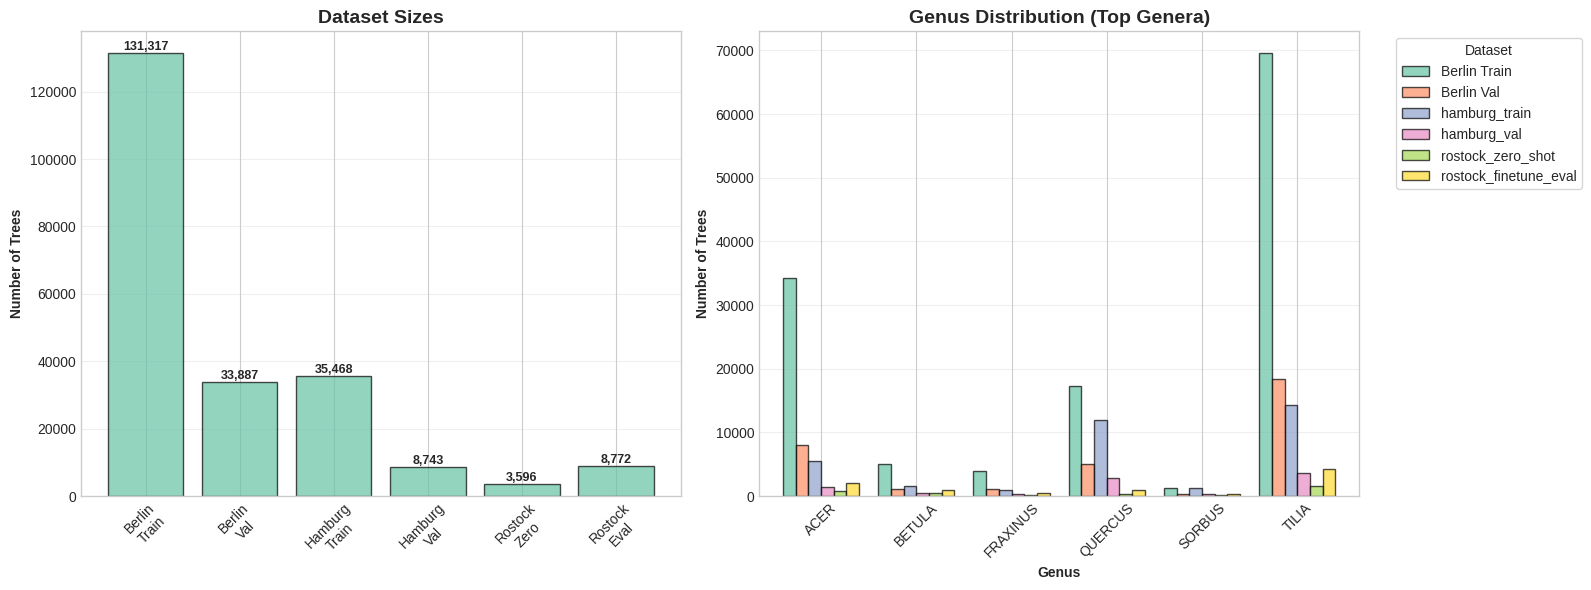

Plot saved: dataset_overview.png


In [33]:
print_subsection("Visualizations")

# Plot 1: Dataset sizes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Dataset size comparison
dataset_names = ['Berlin\nTrain', 'Berlin\nVal', 'Hamburg\nTrain', 'Hamburg\nVal', 'Rostock\nZero', 'Rostock\nEval']
dataset_sizes = [
    len(berlin_train_df),
    len(berlin_val_df),
    len(hamburg_dfs['hamburg_train']),
    len(hamburg_dfs['hamburg_val']),
    len(rostock_dfs['rostock_zero_shot']),
    len(rostock_dfs['rostock_finetune_eval'])
]

bars = ax1.bar(dataset_names, dataset_sizes, edgecolor='black', alpha=0.7)
for bar, size in zip(bars, dataset_sizes):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{size:,}', ha='center', va='bottom', fontweight='bold', fontsize=9)

ax1.set_ylabel('Number of Trees', fontweight='bold')
ax1.set_title('Dataset Sizes', fontweight='bold', fontsize=14)
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Genus counts
genus_data = []
berlin_genera = set(berlin_train_df[LABEL_COL].unique()) # Ensure available

for genus in sorted(berlin_genera):
    row = {'Genus': genus}
    # Berlin
    row['Berlin Train'] = berlin_train_df[berlin_train_df[LABEL_COL] == genus].shape[0]
    row['Berlin Val'] = berlin_val_df[berlin_val_df[LABEL_COL] == genus].shape[0]

    # Hamburg
    for name in ['hamburg_train', 'hamburg_val']:
        df = hamburg_dfs[name]
        row[name] = df[df[LABEL_COL] == genus].shape[0] if genus in df[LABEL_COL].values else 0

    # Rostock
    for name in ['rostock_zero_shot', 'rostock_finetune_eval']:
        df = rostock_dfs[name]
        row[name] = df[df[LABEL_COL] == genus].shape[0] if genus in df[LABEL_COL].values else 0

    genus_data.append(row)

genus_df = pd.DataFrame(genus_data)
genus_df_plot = genus_df.set_index('Genus')

# Select top 20 genera for readability if too many
if len(genus_df_plot) > 20:
    top_genera = berlin_train_df[LABEL_COL].value_counts().head(20).index
    genus_df_plot = genus_df_plot.loc[top_genera]

genus_df_plot.plot(kind='bar', ax=ax2, edgecolor='black', alpha=0.7, width=0.8)
ax2.set_ylabel('Number of Trees', fontweight='bold')
ax2.set_xlabel('Genus', fontweight='bold')
ax2.set_title('Genus Distribution (Top Genera)', fontweight='bold', fontsize=14)
ax2.legend(title='Dataset', frameon=True, bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plot_path = OUTPUT_PLOTS / "dataset_overview.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Plot saved: {plot_path.name}")

### 8.4 Export Summary Report

In [34]:
print_subsection("Export Summary Report")

# Save summary report
report_file = OUTPUT_METADATA / "data_prep_report.json"
with open(report_file, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Summary report saved: {report_file.name}")
print(f"\nReport contains:")
print(f"  - Phase 0 configuration (Top-{FEATURE_COUNT} features)")
print(f"  - Dataset statistics (4 datasets)")
print(f"  - Transfer overlap analysis")
print(f"  - Feature statistics")


----------------------------------------------------------------------
  Export Summary Report
----------------------------------------------------------------------

Summary report saved: data_prep_report.json

Report contains:
  - Phase 0 configuration (Top-50 features)
  - Dataset statistics (4 datasets)
  - Transfer overlap analysis
  - Feature statistics


---

## 9. SUMMARY & NEXT STEPS

In [35]:
print("\n" + "="*70)
print("DATA PREPARATION COMPLETE")
print("="*70)

print("\nOutputs:")
print("-" * 70)
for name, config in DATASETS.items():
    output_path = OUTPUT_DATA / config['output']
    file_size = output_path.stat().st_size / 1024 / 1024
    print(f"  {config['output']:45s} {file_size:>6.1f} MB")

report_size = report_file.stat().st_size / 1024
print(f"  {'data_prep_report.json':45s} {report_size:>6.1f} KB")

print("\nPhase 0 Configuration Applied:")
print("-" * 70)
print(f"  Features selected: Top-{FEATURE_COUNT} (from Experiment 0.3)")
print(f"  Retention vs. Baseline: {RETENTION*100:.1f}%")
print(f"  Dataset: 20m-Edge (from Experiment 0.2)")
print(f"  CHM Strategy: No CHM (from Experiment 0.1)")

print("\nReady for Phase 1 Experiments:")
print("-" * 70)
print(f"  1. RF Hyperparameter Tuning (HIGH PRIORITY)")
print(f"  2. XGBoost Baseline")
print(f"  3. Hamburg Transfer Test (HIGH PRIORITY)")
print(f"  4. Neural Network Experiments")
print(f"  5. Rostock Transfer Test (Optional)")

print("\nNext Notebook:")
print("-" * 70)
print(f"  01_experiment_rf_tuning.ipynb")
print(f"  Goal: Reduce overfitting from 47% to <30%")
print(f"  Load: berlin_20m_edge_top50_train.parquet")

print("\n" + "="*70)
print(f"Notebook execution time: {datetime.now().isoformat()}")
print("="*70)


DATA PREPARATION COMPLETE

Outputs:
----------------------------------------------------------------------
  berlin_20m_edge_top50_train.parquet             31.4 MB
  berlin_20m_edge_top50_val.parquet                8.2 MB
  hamburg_20m_edge_top50_train.parquet             8.7 MB
  hamburg_20m_edge_top50_val.parquet               2.2 MB
  rostock_20m_edge_top50_zero_shot.parquet         1.1 MB
  rostock_20m_edge_top50_finetune_eval.parquet     2.5 MB
  data_prep_report.json                            2.9 KB

Phase 0 Configuration Applied:
----------------------------------------------------------------------
  Features selected: Top-50 (from Experiment 0.3)
  Retention vs. Baseline: 102.5%
  Dataset: 20m-Edge (from Experiment 0.2)
  CHM Strategy: No CHM (from Experiment 0.1)

Ready for Phase 1 Experiments:
----------------------------------------------------------------------
  1. RF Hyperparameter Tuning (HIGH PRIORITY)
  2. XGBoost Baseline
  3. Hamburg Transfer Test (HIGH PRIORITY)

---

**Notebook End**

Exported: 2026-01-19

Author: Silas Pignotti